<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres: Andrés Lares Barragán & Rodrigo Martinez Bertoldi** 

**Fecha: 12/04/2021** .

**Expediente** : 724055, 722268
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**[Link Github](https://github.com/rodrigomart1nez/ProyectoSPF)**
# Proyecto TEMA-2

# Red Bull Racing vs. Mercedes AMG
**Estudio de probabilidades basado en datos históricos.**

# 1 Definición del Proyecto
# <hr>

### 1.2 Objetivos

#### Objetivos Generales  
Determinar que tan probable es que el equipo de Fórmula 1, Red Bull Racing Team, tenga un mejor resultado que su mayor rival, Mercedes AMG Petronas, en el Gran Premio de Italia este 18 de abril.

#### Objetivos Específicos

1. Identificar los conductores que representan a cada equipo esta temporada.
2. Conseguir el **tiempo por vuelta** de cada conductor en el circuito italiano en años pasados. Esta variable nos permite medir y comparar el desempeño de los conductores.
3. Visualizar la distribución de la variable ´tiempo por vuelta´ para cada conductor.
4. Realizando el procedimiento adecuado, determinar la manera óptima de generar valores aleatorios de esta variable.
5. Para cada conductor, generar 1 v.a. por vuelta y calcular su tiempo total en la carrera.
6. Jerarquizar los tiempos totales en carrera de los conductores. 
7. Repetir el paso 5 y 6 de manera iterativa; calcular la probabilidad de que los conductores de Red Bull RT tengan un mejor desempeño que los de Mercedes AMG.

### 1.3  Definción del Problema

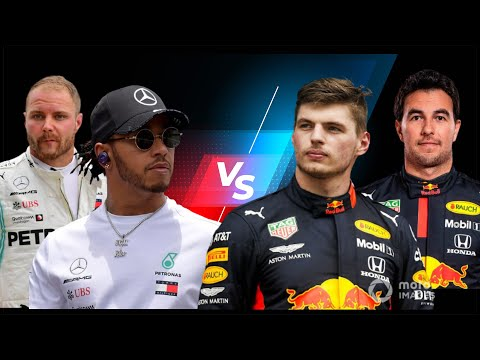

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('J-i-eLyWbqw', width=750, height=450)

#### Contexto


La Fórmula 1 es la clase más alta de carreras automóvilísticas. El Campeonato Mundial de Fórmula 1 de la FIA ha sido una de las principales formas de competir en todo el mundo desde su temporada inaugural en 1950. Una temporada de Fórmula Uno consiste en una serie de carreras, conocidas como Grands Prix, que tienen lugar en cicuitos a lo largo del mundo.

Cada temporada, 10 equipos (concodidos como Constructores) compiten por el Campeonato de Constructores. El equipo de Mercedes AMG ha dominado el campeonato con siete victorias consecutivas (2014-2020). Previo a eso, Red Bull RT fue cuatro veces campeón (2010-2013). 

En esta temporada (2021), el equipo a vencer es Mercedes AMG. El consenso de expertos y analístas de F1 indica que Red Bull RT es el equipo favorito para derrocar al actual campeón: Mercedes.

**El presente trabajo analítico pretende determinar que tan probable es que Red Bull RT obtenga mejores resultados que Mercedes AMG en la siguiente exhibición de la temporada: El Gran Premio Italiano.** 

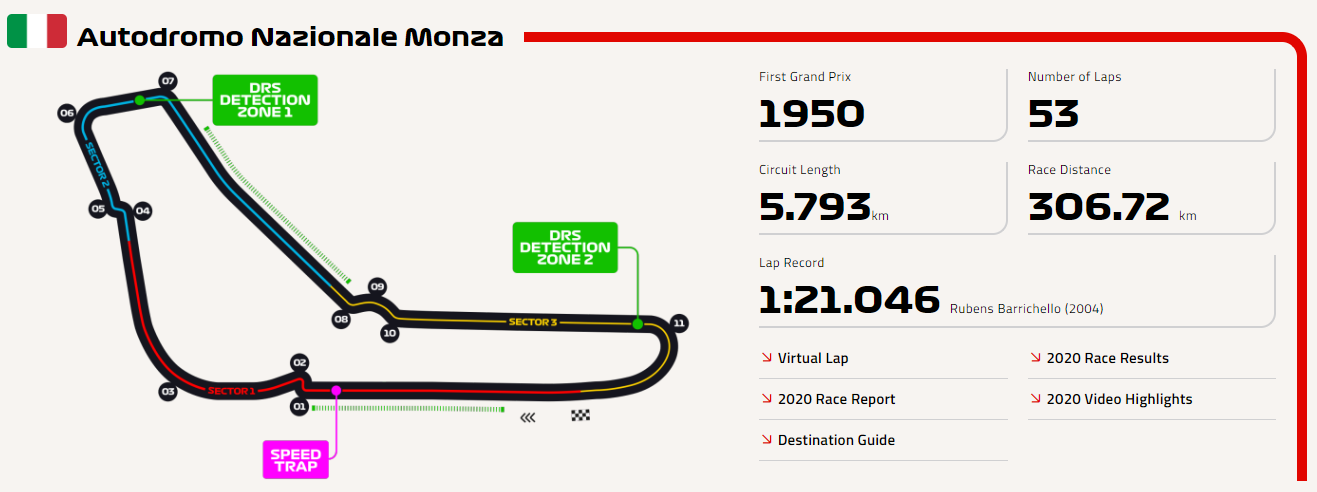

### 1.4 Nodos y Variables por Simular

En cada evento hay un total de 20 conductores en la pista, lo cual significa que un equipo cuenta con dos conductores:
- MERCEDES AMG $\rightarrow$ Lewis Hamilton & Valtteri Bottas
- RED BULL RT  $\rightarrow$  Max Verstappen & Sergio Pérez

Por lo tanto es necesario tomar en cuenta el desempeño de ambos conductores de Red Bull RT y Mercedes AMG para cumplir el objetivo principal.

El desemepeño de los conductores se puede medir tomando el tiempo transcurrido durante cada vuelta.

#### Variable Aleatoria

La variable de interés es el tiempo por vuelta. Se busca identificar la manera de generar valores aleatorios para esta variable con un error de ajuste mínimo. 

#### Nodos

Las especificaciones del circuito indican que la carrera finaliza después de **53 vueltas**.

**Un nodo está definido como el tiempo total que un conductor tomó en terminar la carrera**. Por lo tanto, es necesario generar 53 valores aleatorios de la variable ´tiempo de vuelta´ para cada uno de los cuatro conductores. Matemáticamene, el tiempo total transcurrido a lo largo de la carrera se expresa:

$$
\large{\text{T}_{j} = \sum^{53}_{i=0}{t_i}} \\
\small{
T \rightarrow \text{Tiempo total del conductor j} \\
t \rightarrow \text{Tiempo en vuelta i (Variable Aleatoria)}\\
j \in [\text{Hamilton, Bottas, Verstappen, Pérez}] \\
i \in [1,53]
}
$$

#### Simulación

Una simulación se completa al generar los 53 tiempos de vuelta individuales de cada conductor, ordenar de menor a mayor los tiempos totales y asignar un equipo ganador de la carrera.

Tras 1,000 simulaciones realizadas, se calcula la probabilidad de que Red Bull RT tenga un mejor desempeño que Mercedes AMG.



### 1.5 Hipótesis y Supuestos

#### Hipótesis

De acuerdo al sitio de apuestas en línea DraftKings; la probabilidad de que Mercedes AMG gane el Campeonato de Constructores es de **75.31%**, y la proabilidad de que Red Bull RT sea el campeón es del **22.26%**. [2021 Constructors Championship Odds](https://sportsbook.draftkings.com/leagues/motorsports/153582?category=race-lines&subcategory=finishing-position)

**Se pretende validar las probabilidades de DraftKings, de tal forma que:**

$$
\large{
H_0: p(T_\text{Red Bull RT} < T_\text{Mercedes AMG}) = 22.26\% \\
H_a: p(T_\text{Red Bull RT} < T_\text{Mercedes AMG}) \ne 22.26\% \\
}
\\
\small{
T_{\text{Red Bull RT}} \rightarrow T_{\text{Verstappen}} + T_{\text{Perez}} \\
T_{\text{Mercedes AMG}} \rightarrow T_{\text{Hamilton}} + T_{\text{Bottas}}
}
$$

#### Supuestos
1. La posición de arranque no otorga una ventaja significativa; el tiempo total determina las posiciones finales.
2. El desempeño de los conductores en el mismo cicuito pero años anteriores es indicativo de su próximo desempeño.
3. Los vehículos no otorgan una ventaja significativa.
4. La probabilidad de ganar el campeonato es estadisticamente igual a la probabilidad de ganar el Gran Premio de Italia.

### 1.6 Base de Datos

#### Descripción

La información utilizada se obtuvo de la base de datos *[Formula 1 World Championship (1950 - 2021):
F1 race data from 1950 to 2021](https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020/metadata)* publicada en Kaggle por el usuario *[Vopani](https://www.kaggle.com/rohanrao).*

Dentro de la descripción del dataset, el autor acredita que los datos fueron recopilados usando [Ergast Developer API](http://ergast.com/mrd/).

#### Contenido

El conjunto de datos consta de toda la información sobre las carreras de Fórmula 1: pilotos, constructores, clasificación, circuitos, **tiempos de vuelta**, paradas en boxes, campeonatos desde 1950 hasta el último final de la temporada 2020.

#### Estructura

13 archivos *.csv* detallando elementos de cada carrera desde 1950.

Los archivos de interés y su uso se listan a continuación:
- *races.csv*: Identificar el número de referencia del circuito de Italia $\rightarrow$ **14**.
- *drivers.csv*: Identificar el número de referencia de cada conductor $\rightarrow$ **{Hamilton: 1, Bottas: 822, Verstappen: 830, Pérez: 815}**.
- *lap_times.csv:* Proporciona la información histórica de la variable de interés $\rightarrow$ **milliseconds** (tiempo de vuelta en milisegundos).

Con esta información es posible realizar un filtro de los datos, seleccionando únicamente los tiempos de vuelta de los conductores deseados en el circuito de Italia.

# 2 Simulación de Nodos

### <hr>


In [2]:
# Librerías básicas
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# Librerías estadísticas (Ajustes de distribución)
import scipy.stats as st
import statsmodels.api as sm
# Librerías KDE
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
# Aceptación y Rechazo
from scipy import optimize
# Librerías auxiliares
import warnings
import seaborn as sns

**Limpieza de Datos**

In [3]:
# identificar las observaciones que representan carreras en Italia 
races = pd.read_csv('Data/races.csv')

monza = races[races['circuitId'] == 14]['raceId']
races_monza = []
[races_monza.append(i) for i in monza];
# 'monza' contiene el Id de las carreras en Italia

In [4]:
# cargar dataset de tiempos por vuela
results = pd.read_csv('Data/lap_times.csv')
# fitro del circuito italiano y las variables 
races_monza_results = results[results['raceId'].isin(races_monza)]
races_monza_results = races_monza_results[['driverId','milliseconds']]
# filtro de tiempos por vuelta por piloto
hamilton     = races_monza_results[races_monza_results['driverId'] == 1]
bottas       = races_monza_results[races_monza_results['driverId'] == 822]
verstappen   = races_monza_results[races_monza_results['driverId'] == 830]
perez        = races_monza_results[races_monza_results['driverId'] == 815]
# reinicar el indice de las variables
[var.reset_index(inplace=True) for var in [hamilton,bottas,verstappen,perez]];


## Primer Nodo: Hamilton (Mercedes)

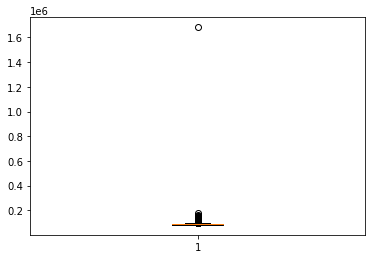

In [5]:
# convertir datos a un array
hami = hamilton['milliseconds'].to_numpy()
# visualizar datos con boxplot
b = plt.boxplot(hami);

In [6]:
# eliminar los valores extremos

lims = [item.get_ydata()[1] for item in b['whiskers']]
hami = hami[(hami > lims[0]) & (hami<lims[1])]

Visualización Preliminar de Ditribución: HAMILTON


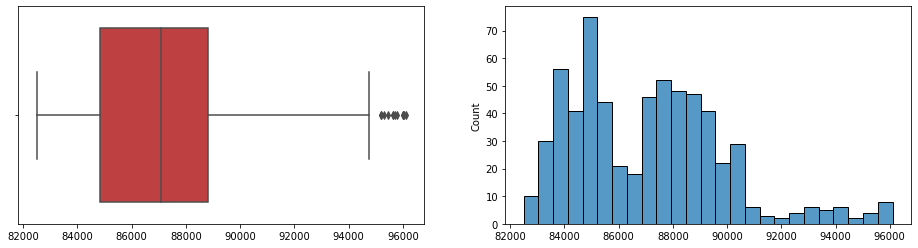

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex= True, figsize=(16,4))
sns.histplot(hami, ax=ax2, bins=25)
sns.boxplot(x=hami, ax=ax1, saturation=.5, color='r')
print('Visualización Preliminar de Ditribución: HAMILTON')
plt.show()

El diagrama de cajas muestra un **sesgo a la derecha** en la distribución. Por otro lado, el histograma sugiere que los datos se distribuyen de manera **bimodal**.

## Ajuste de Distribuciones

In [8]:
# Dataframe que almacena los errores de ajuste de cada distribucion
def erdist(d:"Distribución por ajustar", data:"Datos para el fit"):
    """
    Ajusta las distribuciones continuas de la libreria estadistica de scipy.
    Calcula el error de ajuste de cada distribucion vs. los datos observados.
    """
    # ajuste y aproximacion de la distribucion
    params = getattr(st,d).fit(data)
    y_hat = getattr(st,d)(*params).pdf(x)
    # calcular errores
    Error.loc[d,'RMSE']      = np.sqrt(((y - y_hat)**2).mean())
    Error.loc[d,'R-squared'] = 1 - (np.sum((y - y_hat)**2))/(np.sum((y - np.mean(y))**2))
    return plt.plot(x,y_hat,label=d)

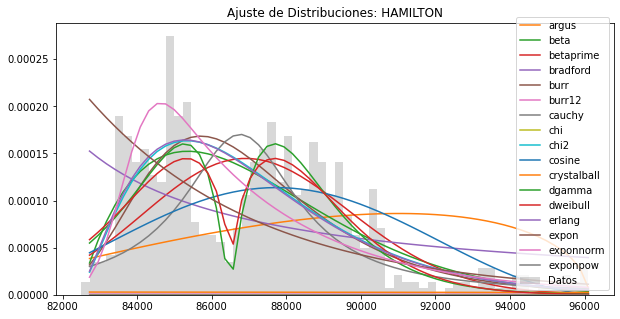

In [9]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5))
y,x, _ = plt.hist(hami, bins=60, label='Datos',fc='gray', histtype='stepfilled', alpha=0.3, density=True)
x = x[1:]

# Tomamos las distribuciones continuas de la paqueteria 'scipy.stats'
dist = [d for d in dir(st) if isinstance(getattr(st,d), getattr(st,'rv_continuous'))]
dist = dist[3:20]

Error = pd.DataFrame(index=dist, columns=['RMSE','R-squared'])

[erdist(d, hami) for d in dist]
plt.title('Ajuste de Distribuciones: HAMILTON')
plt.legend()
plt.show()

In [10]:
Error.transpose()

,argus,beta,betaprime,bradford,burr,burr12,cauchy,chi,chi2,cosine,crystalball,dgamma,dweibull,erlang,expon,exponnorm,exponpow
RMSE,6.94218e-05,4.36087e-05,4.70581e-05,5.88359e-05,4.72514e-05,9.8679e-05,5.8838e-05,9.91876e-05,4.47798e-05,5.18338e-05,9.7155e-05,3.4192e-05,3.62087e-05,4.47729e-05,6.29863e-05,4.71214e-05,9.91876e-05
R-squared,-0.0869182,0.571106,0.500571,0.21929,0.496459,-1.19611,0.219236,-1.21881,0.547759,0.394058,-1.1288,0.736335,0.704315,0.547899,0.10526,0.499226,-1.21881


La métrica de error **RMSE** representa la raíz de la suma de los errores cuadrados. Entre menor sea el valor, mejor es el ajuste de la distribución y viceversa.

Sea $R^2$ el coeficiente de determinación entre los valores aproximados y los observados, un valor cercano a 1 indica un buen ajuste. Por otro lado, los valores de $R^2$ cercanos a cero sugieren que la distribución ajustada no es adecuada para los datos. 

In [11]:
bestRMSE = Error.sort_values(by='RMSE',ascending=True).head().index.values
bestR2   = Error.sort_values(by='R-squared',ascending=False).head().index.values
bestRMSE, bestR2

(array(['dgamma', 'dweibull', 'beta', 'erlang', 'chi2'], dtype=object),
 array(['dgamma', 'dweibull', 'beta', 'erlang', 'chi2'], dtype=object))

Por ambas métricas de error, se concluye que la distribución **dgamma** se ajusta mejor a los datos.

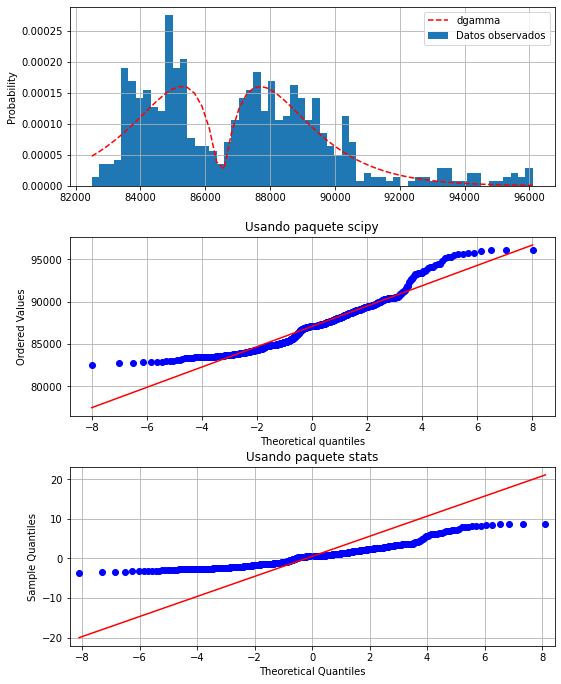

In [12]:
measurements = hami

# Histograma de las variables creadas
divisiones = 60 # Cantidad de barras en el histograma
fig, ax = plt.subplots(3,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

y, x, _ = ax[0].hist(measurements, divisiones, density=True, label='Datos observados')

# pdf con mejor ajuste segun RMSE y R^2: dgamma
dist = 'dgamma'
params = getattr(st, dist).fit(measurements)

# Graficar
# x = np.arange(measurements.min(), measurements.max(), .01)
y_hat = getattr(st, dist).pdf(x, *params)
ax[0].plot(x, y_hat,'r--', label=dist)
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()

# gráfica de Q-Q
# Usando scipy
grap2 = st.probplot(measurements, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')
# Usando stats
grap1 = sm.qqplot(measurements, dist=getattr(st, dist), line='s', fit=True, ax=ax[2])
ax[2].grid()
ax[2].set_title('Usando paquete stats')

# plt.xlabel(f'{dist.title()} theorical quantiles')
# plt.ylabel('Data theorical quantiles')
plt.show()

El diagrama Quantil-Quantil de la paquetería de *stats* expone errores de ajsute en ambas colas de la distribución.
Adicionalmente, la distribución teorica está más dispersa que la distribución de la librería stats. 

In [13]:
print("Parámetros de la distribución dgamma \n","Alpha: ",params[0],"\n","Loc: ",params[1],"\n","Scale: ",params[2])

Parámetros de la distribución dgamma 
 Alpha:  2.0869278259397728 
 Loc:  86484.18452766787 
 Scale:  1107.047275976473


$H_0:$ Los datos tienen una distribución dgamma con parámetros $\alpha = 2.0869,\quad \text{Loc}:  86484.1845,  \quad
 \text{Scale}: 1107.0473$.
 
$H_a:$ Los datos no tienen una distribución dgamma  con parámetros $\alpha = 2.0869,\quad \text{Loc}:  86484.1845,  \quad
 \text{Scale}: 1107.0473$.

In [14]:
# Generar una distribucion dgamma con los parametros obtenidos
pi = st.dgamma.pdf(x, params[0], params[1], params[2]) #
# Chi cuadrado
Ei = x*pi
X2 = st.chisquare(y, Ei[1:])
print('Valor de chi cuadrado librería = ', X2)

Valor de chi cuadrado librería =  Power_divergenceResult(statistic=354.8053219295775, pvalue=8.173489142705667e-44)


**El p value es muy cercano a cero, se rechaza la hipótesis nula.**

## Kernel Density Estimator

In [15]:
def kde_sklearn(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

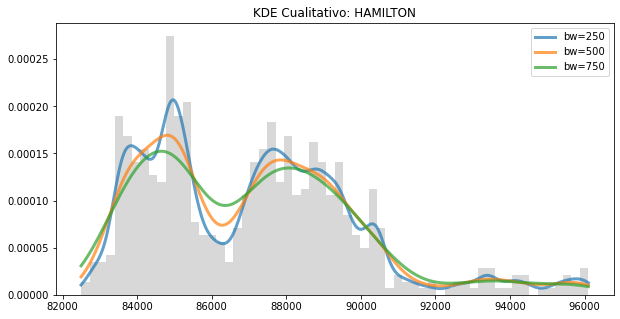

In [16]:
x_grid1 = np.linspace(min(hami),max(hami), 100000)

plt.figure(figsize=(10,5))
for bandwidth in [250,500,750]:
    plt.plot(x_grid1, kde_sklearn(hami, x_grid1, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
    
plt.hist(hami, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.title("KDE Cualitativo: HAMILTON")
plt.legend(loc='upper right')
plt.show()

De la gráfica podemos asumir que el valor óptimo es **menor a 500**.

**Optimización de bandwidth**

In [17]:
grid1 = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(100, 400, 100)},
                    cv=200) # 150-fold cross-validation
#hami=np.array(hami)
grid1.fit(hami[:, None])
print(grid1.best_params_)

{'bandwidth': 327.27272727272725}


Según el método de cross validation, el valor óptimo para los bandwidths es de **327.27**.

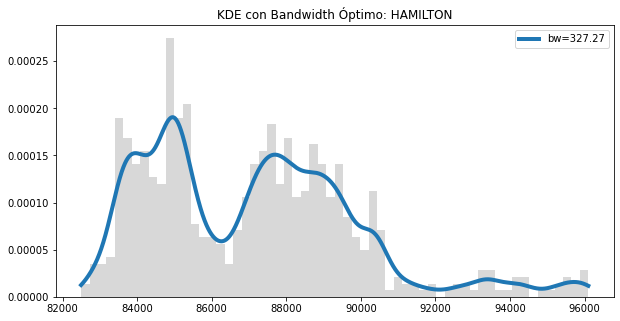

In [18]:
# Ajuste del KDE optimo
pdf_kde1 = KernelDensity(kernel='gaussian', bandwidth = 327.27).fit(hami[:, np.newaxis])
# Obtener una PDF de acuerdo al KDE óptimo.
PDF1 = lambda x: np.exp(pdf_kde1.score_samples(x[:, None]))

# graficar KDE con valor bw optimo
plt.figure(figsize=(10,5))
plt.plot(x_grid1, PDF1(x_grid1), label='bw=327.27',linewidth = 4)
plt.hist(hami, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.legend(loc='upper right')
plt.title("KDE con Bandwidth Óptimo: HAMILTON")
plt.show()

## Generar Variables Aleatorias

In [19]:
# Función de aceptación y rechazo usando compresión de listas
def Acep_rechazo_n(R2:'Variables distribuidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 pdf:'función objetivo a generar',
                 t:'función que mayora a f',
                 q:'cantidad de valores por retornar'):
    '''
    Genera ´q´ valores aleatorios con distribución pdf. 
    Utiliza el método de aceptación rechazo.
    '''
    # Evaluar el cumplimiento de la condicion para cada dato.
    f_x = pdf(R1)
    t_x = t(R1)
    condition = R2*t_x <= f_x # lista de booleanos con dimension len(R2) = len(R1)
    
    # inicializar variables
    x  = []    # variable donde almaceno los valores que cumplen la condicion.
    i  = 0
    # Aceptar valores de manera iterativa hasta tener q valores aceptados
    while len(x)<q:        
        if condition[i] == True:
            plt.plot(R1[i], R2[i]*t_x[i],'go' )
            x.append(R1[i])
        else:
            plt.plot(R1[i], R2[i]*t_x[i],'ro')
        i += 1  # siguiente valor
    
    plt.hist(x, bins=30, density=True)
    plt.plot(x_grid1, pdf(x_grid1))
    return x

def estratos_cttes(a:"Límite inferior de dist.",
                   b:"Límite superior de dist.",
                   N:"Cantidad de valores por generar"):
    """
    Genera N valores estratificados igualmente espaciados.
    """
    # Un estrato por cada valor generado
    U = np.random.uniform(size=N)
    B = N
    i = np.arange(0, B)
    U_est = (U + i) / B # estratificado entre [0,1].
    return (U_est*(b-a) + a)# retorna los valores estratificados entre [a,b].
    

# Muestreo con números complementarios
def num_complem(a:"Límite inferior del dominio",
               b:"Límite superior del dominio",
               N:"Cantidad de valores por generar"):
    """
    Retorna N/2 valores generados aleatoriamente y sus N/2 valores complementarios respectivos.
    """
    U      = np.random.uniform(a, b, int(N/2))
    U_comp = b - U + a
    return np.concatenate([U, U_comp]) 

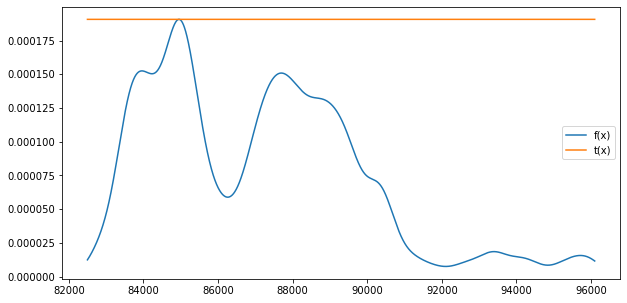

In [20]:
max_f1 = PDF1(x_grid1).max()
t1     = lambda x: max_f1 * np.ones([len(x)])

# Visualizacion de ambas funciones
plt.figure(figsize=(10,5))
plt.plot(x_grid1,PDF1(x_grid1),label='f(x)')
plt.plot(x_grid1,t1(x_grid1),label='t(x)')
plt.legend()
plt.show()

Variables Aleatorios con Estratos Constantes: HAMILTON


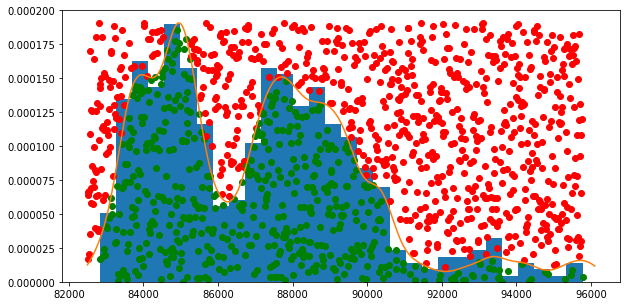

In [21]:
# I. Estratos constantes
N1     = 1300
a1     = min(hami)
b1     = max(hami)

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Estratos Constantes: HAMILTON')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = estratos_cttes(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_I  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1,500)

Variables Aleatorios con Números Complementarios: HAMILTON


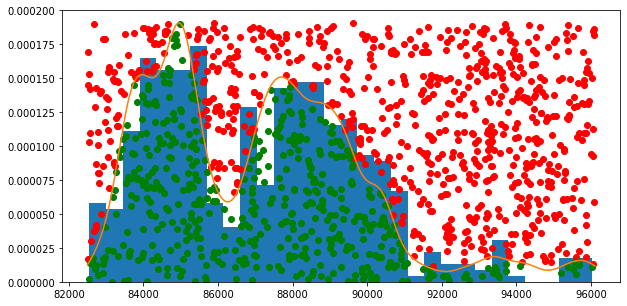

In [22]:
# II. Numeros complementarios

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Números Complementarios: HAMILTON')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = num_complem(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_II  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1, 500)
plt.show()

**Utilizando la técnica de reducción de varianza de números complementarios, se generan 53 valores de acuerdo a la distribución KDE con bandwidth óptimo.** Recordemos que cada valor representa el tiempo transcurrido en 1 vuelta al circuito. 

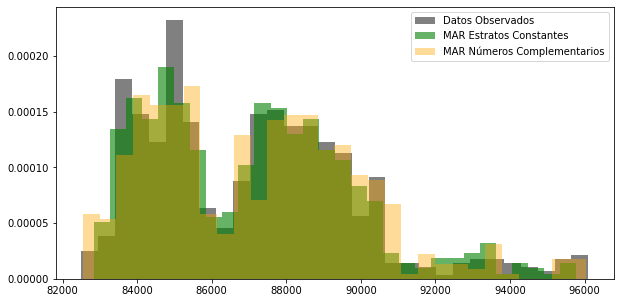

In [23]:
plt.figure(figsize=(10,5))
plt.hist(hami,bins=30, density=True, color="grey", alpha=1, label="Datos Observados")
plt.hist(MAR1_I,bins=30, density=True, color="green", alpha=.6, label="MAR Estratos Constantes")
plt.hist(MAR1_II,bins=30, density=True, color="orange", alpha=.4, label="MAR Números Complementarios")
plt.legend()
plt.show()

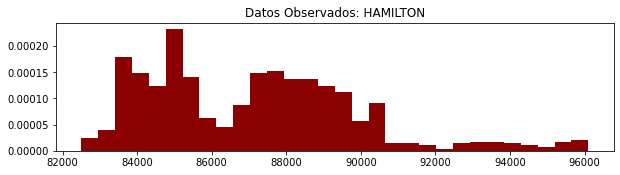

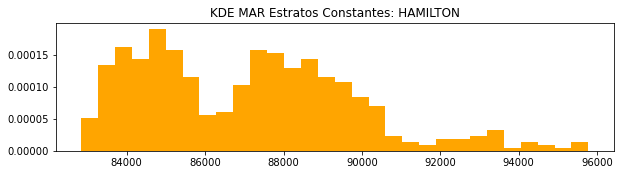

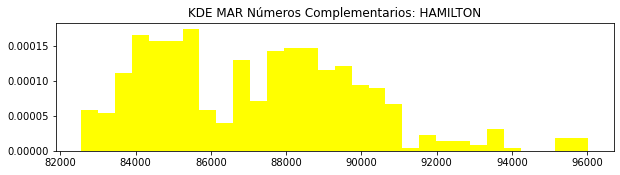

In [24]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(hami, density=True, bins=30,color="darkred")
plt.title('Datos Observados: HAMILTON')
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_I, density=True, bins=30,color="orange")
plt.title("KDE MAR Estratos Constantes: HAMILTON")
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_II, density=True, bins=30, color="yellow")
plt.title('KDE MAR Números Complementarios: HAMILTON')
plt.show()

Los valores generados con la técnica de números complementarios presentar un mejor ajuste.

# MonteCarlo

In [25]:
def Acep_rechazo_na(R2:'Variables distribuidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 pdf:'función objetivo a generar',
                 t:'función que mayora a f',
                 q:'cantidad de valores por retornar'):
    '''
    Genera ´q´ valores aleatorios con distribución pdf. 
    Utiliza el método de aceptación rechazo.
    '''
    # Evaluar el cumplimiento de la condicion para cada dato.
    f_x = pdf(R1)
    t_x = t(R1)
    condition = R2*t_x <= f_x # lista de booleanos con dimension len(R2) = len(R1)
    
    # inicializar variables
    x  = []    # variable donde almaceno los valores que cumplen la condicion.
    i  = 0
    # Aceptar valores de manera iterativa hasta tener q valores aceptados
    while len(x)<q:        
        if condition[i] == True:
            x.append(R1[i])
        i += 1  # siguiente valor

    return x

In [26]:
Resultados = pd.DataFrame(columns=["Hamilton","Bottas","Verstappen","Perez"])
Total_Hamilton = [sum(Acep_rechazo_na(np.random.rand(N1), num_complem(a1,b1,N1), PDF1, t1, 53)) for i in range(250)]
Resultados.Hamilton = Total_Hamilton

In [27]:
Resultados

,Hamilton,Bottas,Verstappen,Perez
0,4.582712e+06,NaN,NaN,NaN
1,4.605478e+06,NaN,NaN,NaN
2,4.619938e+06,NaN,NaN,NaN
3,4.585095e+06,NaN,NaN,NaN
4,4.580603e+06,NaN,NaN,NaN
...,...,...,...,...
245,4.589023e+06,NaN,NaN,NaN
246,4.634999e+06,NaN,NaN,NaN
247,4.655679e+06,NaN,NaN,NaN
248,4.620944e+06,NaN,NaN,NaN


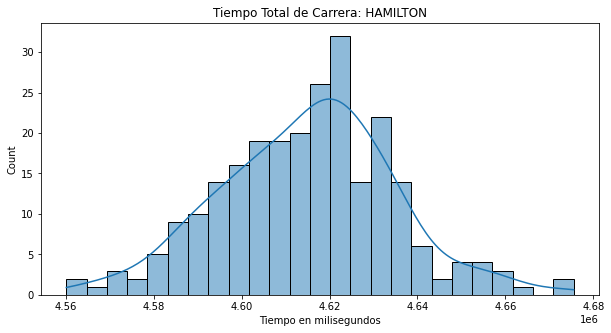

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(Total_Hamilton, bins=25,kde=True)
plt.title("Tiempo Total de Carrera: HAMILTON")
plt.xlabel("Tiempo en milisegundos")
plt.show()

In [29]:
np.mean(Total_Hamilton)

4615040.165781942

### Segundo Nodo: Bottas (Mercedes)

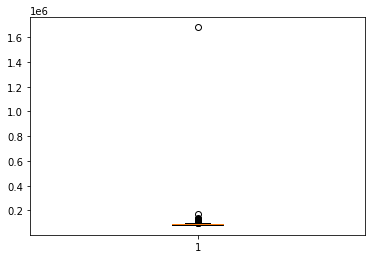

In [30]:
# convertir datos a un array
bot = bottas['milliseconds'].to_numpy()
# visualizar datos con boxplot
b = plt.boxplot(bot);

In [31]:
# eliminar los valores extremos

lims = [item.get_ydata()[1] for item in b['whiskers']]
bot = bot[(bot > lims[0]) & (bot<lims[1])]

Visualización Preliminar de Ditribución: BOTTAS


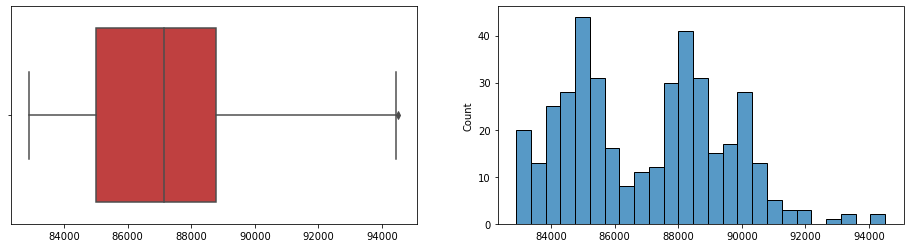

In [32]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex= True, figsize=(16,4))
sns.histplot(bot, ax=ax2, bins=25)
sns.boxplot(x=bot, ax=ax1, saturation=.5, color='r')
print('Visualización Preliminar de Ditribución: BOTTAS')
plt.show()

## Ajuste de Distribuciones

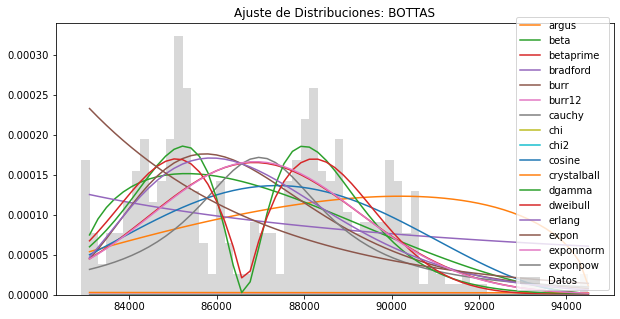

In [33]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,5))
y,x, _ = plt.hist(bot, bins=60, label='Datos',fc='gray', histtype='stepfilled', alpha=0.3, density=True)
x = x[1:]

# Tomamos las distribuciones continuas de la paqueteria 'scipy.stats'
dist = [d for d in dir(st) if isinstance(getattr(st,d), getattr(st,'rv_continuous'))]
dist = dist[3:20]

Error = pd.DataFrame(index=dist, columns=['RMSE','R-squared'])

[erdist(d, bot) for d in dist]
plt.title('Ajuste de Distribuciones: BOTTAS')
plt.legend()
plt.show()

In [34]:
Error.transpose()

,argus,beta,betaprime,bradford,burr,burr12,cauchy,chi,chi2,cosine,crystalball,dgamma,dweibull,erlang,expon,exponnorm,exponpow
RMSE,7.97319e-05,6.01734e-05,6.49657e-05,6.93483e-05,6.53656e-05,0.000114956,7.65532e-05,0.00011547,0.00011547,6.20147e-05,0.000113419,4.77939e-05,4.62442e-05,6.43242e-05,7.42224e-05,6.52791e-05,0.00011547
R-squared,-0.0753266,0.387529,0.286089,0.186517,0.277273,-1.23533,0.00870588,-1.25534,-1.25534,0.349472,-1.17593,0.613614,0.638265,0.300119,0.0681501,0.279183,-1.25534


In [35]:
bestRMSE = Error.sort_values(by='RMSE',ascending=True).head().index.values
bestR2   = Error.sort_values(by='R-squared',ascending=False).head().index.values
bestRMSE, bestR2

(array(['dweibull', 'dgamma', 'beta', 'cosine', 'erlang'], dtype=object),
 array(['dweibull', 'dgamma', 'beta', 'cosine', 'erlang'], dtype=object))

Por ambas métricas de error, se concluye que la distribución **dgamma** se ajusta mejor a los datos.

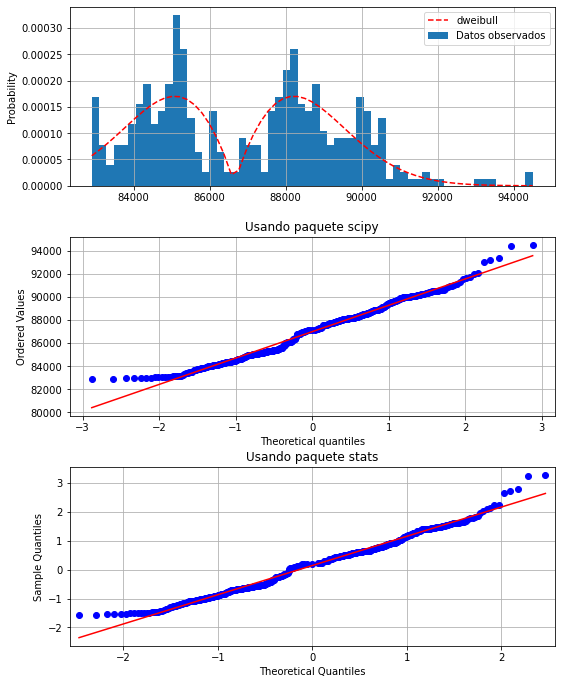

In [36]:
measurements = bot

# Histograma de las variables creadas
divisiones = 60 # Cantidad de barras en el histograma
fig, ax = plt.subplots(3,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

y, x, _ = ax[0].hist(measurements, divisiones, density=True, label='Datos observados')

# pdf con mejor ajuste segun RMSE y R^2: dgamma
dist = 'dweibull'
params = getattr(st, dist).fit(measurements)

# Graficar
# x = np.arange(measurements.min(), measurements.max(), .01)
y_hat = getattr(st, dist).pdf(x, *params)
ax[0].plot(x, y_hat,'r--', label=dist)
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()

# gráfica de Q-Q
# Usando scipy
grap2 = st.probplot(measurements, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')
# Usando stats
grap1 = sm.qqplot(measurements, dist=getattr(st, dist), line='s', fit=True, ax=ax[2])
ax[2].grid()
ax[2].set_title('Usando paquete stats')

# plt.xlabel(f'{dist.title()} theorical quantiles')
# plt.ylabel('Data theorical quantiles')
plt.show()

Se ajusta bastante bien la distribución dweibull, con un poco de sesgo en las colas

In [37]:
print("Parámetros de la distribución dweibull \n","Alpha: ",params[0],"\n","Loc: ",params[1],"\n","Scale: ",params[2])

Parámetros de la distribución dweibull 
 Alpha:  1.8439963129711783 
 Loc:  86649.48705378691 
 Scale:  2397.3834674896534


$H_0:$ Los datos tienen una distribución dweibull con parámetros $\alpha = 1.844,\quad \text{Loc}:  86649.487,  \quad
 \text{Scale}: 2397.3835$.
 
$H_a:$ Los datos no tienen una distribución dweibull  con parámetros $\alpha = 1.844,\quad \text{Loc}:  86649.487,  \quad
 \text{Scale}: 2397.3835$.

In [38]:
# Generar una distribucion dgamma con los parametros obtenidos
pi = st.dweibull.pdf(x, params[0], params[1], params[2]) #
# Chi cuadrado
Ei = x*pi
X2 = st.chisquare(y, Ei[1:])
print('Valor de chi cuadrado librería = ', X2)

Valor de chi cuadrado librería =  Power_divergenceResult(statistic=424.17281924396576, pvalue=1.1130133029973315e-56)


**El p value es muy cercano a cero, se rechaza la hipótesis nula.**

## Kernel Density Estimator

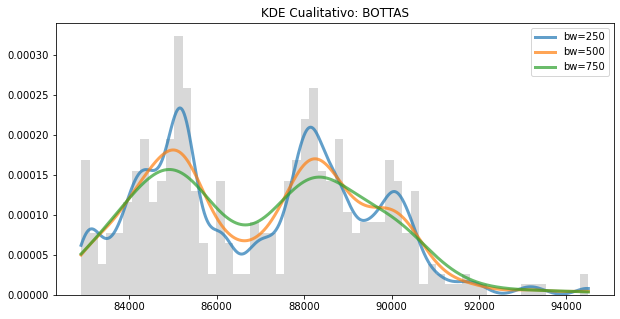

In [39]:
x_grid1 = np.linspace(min(bot),max(bot), 100000)

plt.figure(figsize=(10,5))
for bandwidth in [250,500,750]:
    plt.plot(x_grid1, kde_sklearn(bot, x_grid1, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
    
plt.hist(bot, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.title("KDE Cualitativo: BOTTAS")
plt.legend(loc='upper right')
plt.show()

De la gráfica podemos asumir que el valor óptimo es **menor a 250**.

**Optimización de bandwidth**

In [40]:
grid1 = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(100, 250, 100)},
                    cv=200) # 150-fold cross-validation
#bot=np.array(bot)
grid1.fit(bot[:, None])
print(grid1.best_params_)

{'bandwidth': 171.21212121212122}


Según el método de cross validation, el valor óptimo para los bandwidths es de **171.21**.

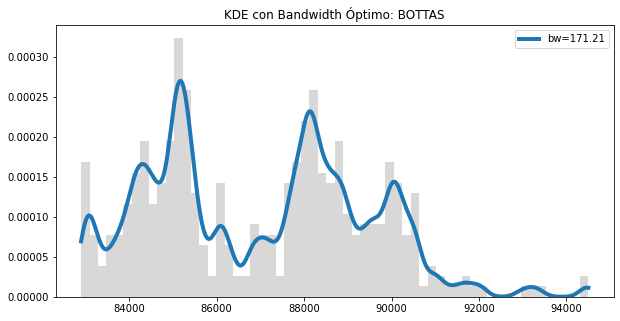

In [41]:
# Ajuste del KDE optimo
pdf_kde1 = KernelDensity(kernel='gaussian', bandwidth = 171.21).fit(bot[:, np.newaxis])
# Obtener una PDF de acuerdo al KDE óptimo.
PDF1 = lambda x: np.exp(pdf_kde1.score_samples(x[:, None]))

# graficar KDE con valor bw optimo
plt.figure(figsize=(10,5))
plt.plot(x_grid1, PDF1(x_grid1), label='bw=171.21',linewidth = 4)
plt.hist(bot, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.legend(loc='upper right')
plt.title("KDE con Bandwidth Óptimo: BOTTAS")
plt.show()

## Generar Variables Aleatorias

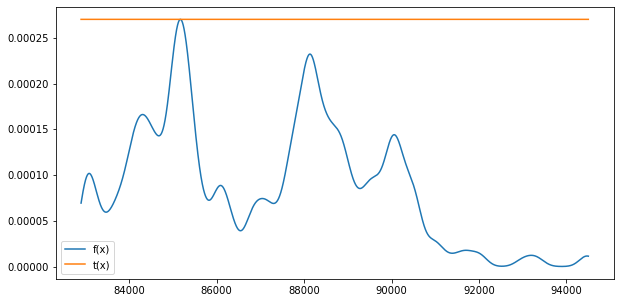

In [42]:
max_f1 = PDF1(x_grid1).max()
t1     = lambda x: max_f1 * np.ones([len(x)])

# Visualizacion de ambas funciones
plt.figure(figsize=(10,5))
plt.plot(x_grid1,PDF1(x_grid1),label='f(x)')
plt.plot(x_grid1,t1(x_grid1),label='t(x)')
plt.legend()
plt.show()

Variables Aleatorios con Estratos Constantes: BOTTAS


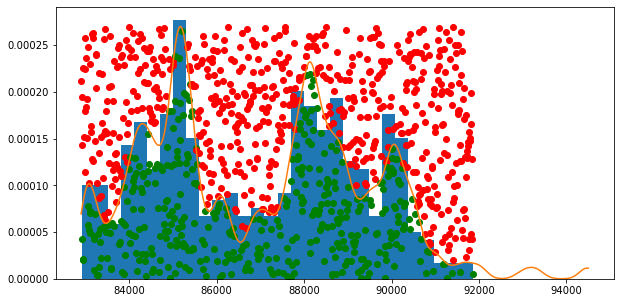

In [43]:
# I. Estratos constantes
N1     = 1300
a1     = min(bot)
b1     = max(bot)

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Estratos Constantes: BOTTAS')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = estratos_cttes(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_I  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1,400)

Variables Aleatorios con Números Complementarios: BOTTAS


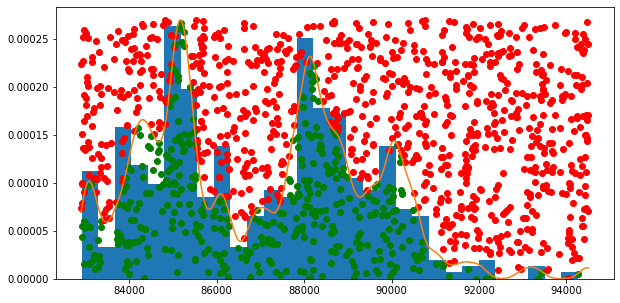

In [44]:
# II. Numeros complementarios

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Números Complementarios: BOTTAS')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = num_complem(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_II  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1, 400)
plt.show()

**Utilizando la técnica de reducción de varianza de números complementarios, se generan 53 valores de acuerdo a la distribución KDE con bandwidth óptimo.** Recordemos que cada valor representa el tiempo transcurrido en 1 vuelta al circuito.

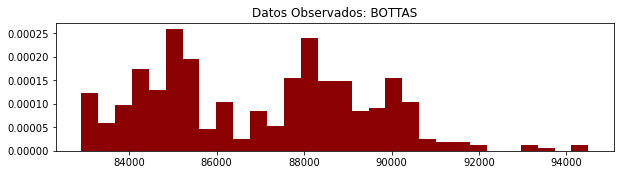

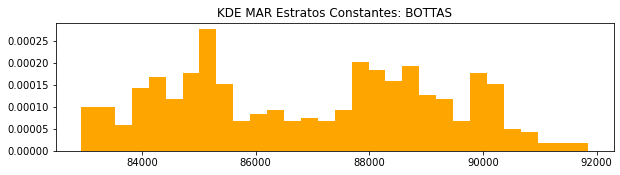

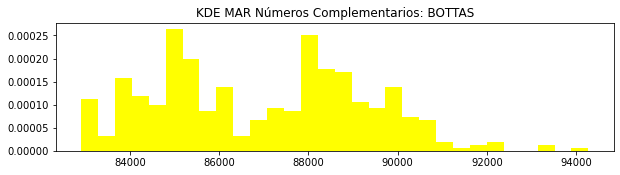

In [45]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(bot, density=True, bins=30,color="darkred")
plt.title('Datos Observados: BOTTAS')
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_I, density=True, bins=30,color="orange")
plt.title("KDE MAR Estratos Constantes: BOTTAS")
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_II, density=True, bins=30, color="yellow")
plt.title('KDE MAR Números Complementarios: BOTTAS')
plt.show()

In [46]:
#Error relativo estratos constantes
np.mean(np.abs(bot-MAR1_I[1:])/bot)

0.04675385606249645

In [47]:
#Error relativo num complementarios
np.mean(np.abs(bot-MAR1_II[1:])/bot)

0.03059306863812605

# MonteCarlo

In [48]:
Total_Bottas = [sum(Acep_rechazo_na(np.random.rand(N1), num_complem(a1,b1,N1), PDF1, t1, 53)) for i in range(250)]
Resultados.Bottas = Total_Bottas

In [49]:
Resultados

,Hamilton,Bottas,Verstappen,Perez
0,4.582712e+06,4.599305e+06,NaN,NaN
1,4.605478e+06,4.600155e+06,NaN,NaN
2,4.619938e+06,4.629442e+06,NaN,NaN
3,4.585095e+06,4.598643e+06,NaN,NaN
4,4.580603e+06,4.605537e+06,NaN,NaN
...,...,...,...,...
245,4.589023e+06,4.626863e+06,NaN,NaN
246,4.634999e+06,4.595630e+06,NaN,NaN
247,4.655679e+06,4.615924e+06,NaN,NaN
248,4.620944e+06,4.603237e+06,NaN,NaN


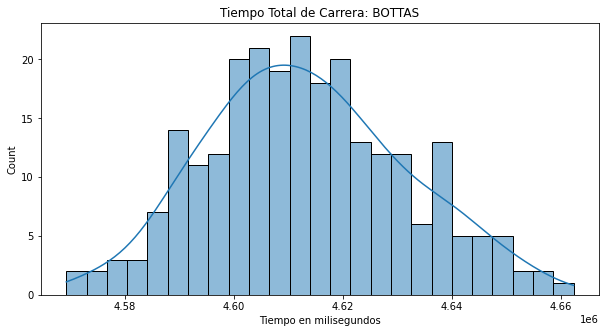

In [50]:
plt.figure(figsize=(10,5))
sns.histplot(Total_Bottas, bins=25,kde=True)
plt.title("Tiempo Total de Carrera: BOTTAS")
plt.xlabel("Tiempo en milisegundos")
plt.show()

In [51]:
np.mean(Total_Bottas)

4613213.028214649

## Tercer Nodo: Verstappen (RedBull)

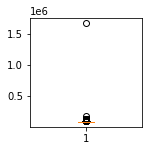

In [52]:
plt.figure(figsize=(2,2))
vers= verstappen['milliseconds'].to_numpy()
b3  = plt.boxplot(vers) 

Visualización Preliminar de Ditribución: VERSTAPPEN


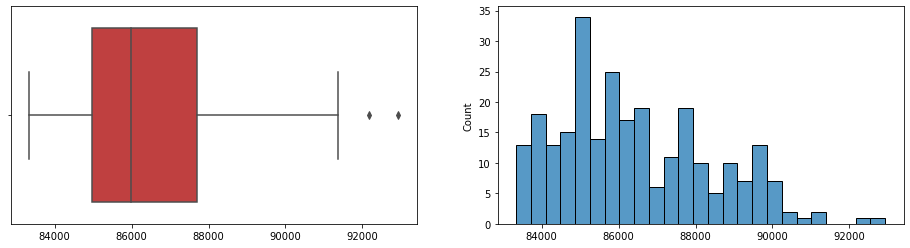

In [53]:
# eliminar los valores extremos
lims = [item.get_ydata()[1] for item in b3['whiskers']]
vers = vers[(vers > lims[0]) & (vers<lims[1])]
fig,(ax1,ax2) = plt.subplots(1,2,sharex= True, figsize=(16,4))
sns.histplot(vers, ax=ax2, bins=25)
sns.boxplot(x=vers, ax=ax1, saturation=.5, color='r')
print('Visualización Preliminar de Ditribución: VERSTAPPEN')
plt.show()

El diagrama de cajas y el histograma muestran un **sesgo a la derecha** en la distribución. Por otro lado, la distribución no parecer ser bimodal en esta ocasión.

### Ajuste de Distribuciones

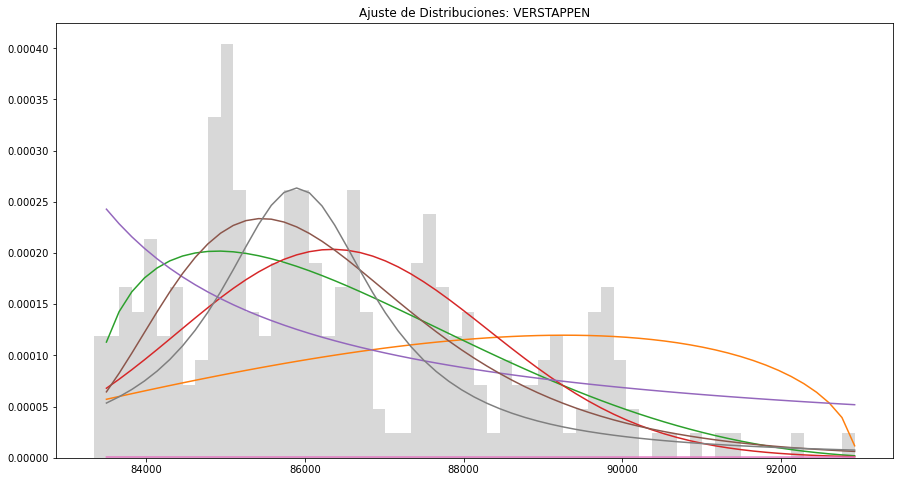

In [54]:
#warnings.filterwarnings('ignore')
plt.figure(figsize=(15,8))
y,x, _ = plt.hist(vers, bins=60, label='Datos',fc='gray', histtype='stepfilled', alpha=0.3, density=True)
x = x[1:]

# Tomamos las distribuciones continuas de la paqueteria 'scipy.stats'
dist = [d for d in dir(st) if isinstance(getattr(st,d), getattr(st,'rv_continuous'))]
dist = dist[3:10]
#dist = ['johnsonsb', 'johnsonsu','kstwobign']
Error = pd.DataFrame(index=dist, columns=['RMSE','R-squared'])

[erdist(d,vers) for d in dist]
plt.title('Ajuste de Distribuciones: VERSTAPPEN')
plt.show()

In [55]:
bestRMSE = Error.sort_values(by='RMSE',ascending=True).head().index.values
bestR2   = Error.sort_values(by='R-squared',ascending=False).head().index.values
bestRMSE, bestR2

(array(['beta', 'burr', 'betaprime', 'cauchy', 'bradford'], dtype=object),
 array(['beta', 'burr', 'betaprime', 'cauchy', 'bradford'], dtype=object))

Basado en las dos métricas de error, se concluye que la distribución con mejor ajuste es **BETA**.

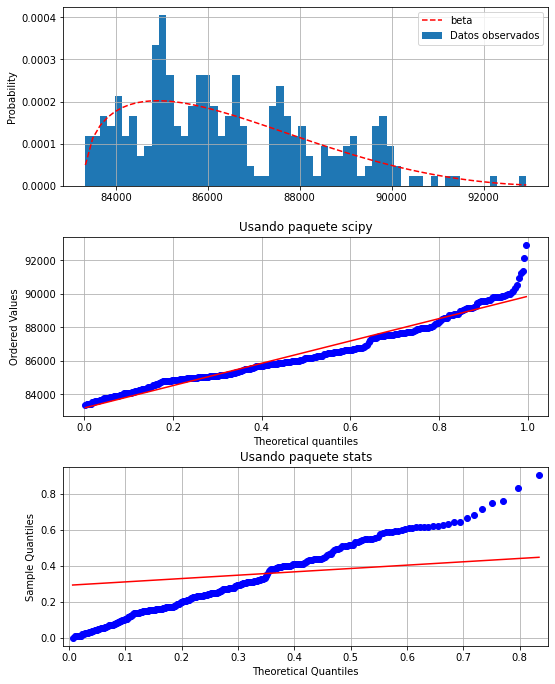

In [56]:
measurements = vers

# Histograma de las variables creadas
divisiones = 60 # Cantidad de barras en el histograma
fig, ax = plt.subplots(3,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

y, x, _ = ax[0].hist(measurements, divisiones, density=True, label='Datos observados')

# pdf con mejor ajuste segun RMSE y R^2: dgamma
dist = 'beta'
params = getattr(st, dist).fit(measurements)

# Graficar
# x = np.arange(measurements.min(), measurements.max(), .01)
y_hat = getattr(st, dist).pdf(x, *params)
ax[0].plot(x, y_hat,'r--', label=dist)
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()

# gráfica de Q-Q
# Usando scipy
grap2 = st.probplot(measurements, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')
# Usando stats
grap1 = sm.qqplot(measurements, dist=getattr(st, dist), line='s', fit=True, ax=ax[2])
ax[2].grid()
ax[2].set_title('Usando paquete stats')

# plt.xlabel(f'{dist.title()} theorical quantiles')
# plt.ylabel('Data theorical quantiles')
plt.show()

Cualitativamente, se concluye que la distribución **Beta** no es adecuada. Pasamos a la prueba de hipótesis para verificar.

**Prueba de Hipótesis**

In [57]:
params

(1.4363619835048644, 3.4823749486171125, 83312.62141923096, 10641.280679499805)

In [58]:
print("Parámetros de la distribución dgamma \n","a: ",params[0],"\n","b: ",params[1],"\n","loc: ",params[2],'\n',"scale: ",params[3])

Parámetros de la distribución dgamma 
 a:  1.4363619835048644 
 b:  3.4823749486171125 
 loc:  83312.62141923096 
 scale:  10641.280679499805


In [59]:
# Generar una distribucion dgamma con los parametros obtenidos
pi = st.beta.pdf(x, params[0], params[1], params[2],params[3]) #
# Chi cuadrado
Ei = x*pi
X2 = st.chisquare(y, Ei[1:])
print('Valor de chi cuadrado librería = ', X2)

Valor de chi cuadrado librería =  Power_divergenceResult(statistic=537.2371575900088, pvalue=2.5458951292746183e-78)


**El p value es muy cercano a cero, se rechaza la hipótesis nula.**

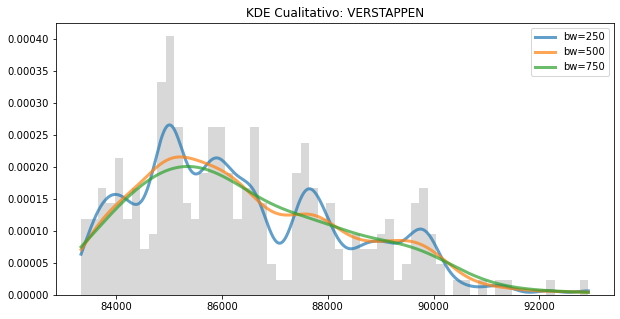

In [60]:
x_grid1 = np.linspace(min(vers),max(vers), 100000)

plt.figure(figsize=(10,5))
for bandwidth in [250,500,750]:
    plt.plot(x_grid1, kde_sklearn(vers, x_grid1, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
    
plt.hist(vers, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.title("KDE Cualitativo: VERSTAPPEN")
plt.legend(loc='upper right')
plt.show()

El bandwidth de 250 parece ser demasiado sensible a los datos observados.

**Optimización de bandwidth**

In [61]:
grid1 = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(100, 400, 100)},
                    cv=200) # 150-fold cross-validation
grid1.fit(vers[:, None])
print(grid1.best_params_)

{'bandwidth': 278.78787878787875}


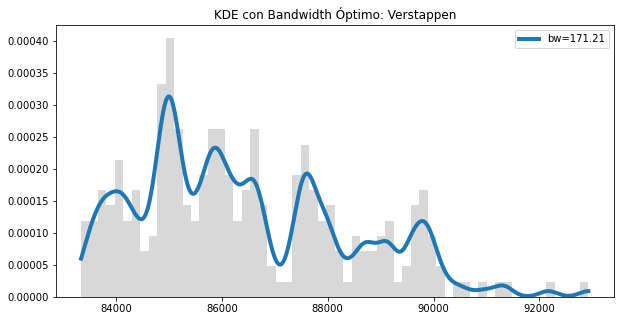

In [62]:
# Ajuste del KDE optimo
pdf_kde1 = KernelDensity(kernel='gaussian', bandwidth = 171.21).fit(vers[:, np.newaxis])
# Obtener una PDF de acuerdo al KDE óptimo.
PDF1 = lambda x: np.exp(pdf_kde1.score_samples(x[:, None]))

# graficar KDE con valor bw optimo
plt.figure(figsize=(10,5))
plt.plot(x_grid1, PDF1(x_grid1), label='bw=171.21',linewidth = 4)
plt.hist(vers, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.legend(loc='upper right')
plt.title("KDE con Bandwidth Óptimo: Verstappen")
plt.show()

## Generar Variables Aleatorias

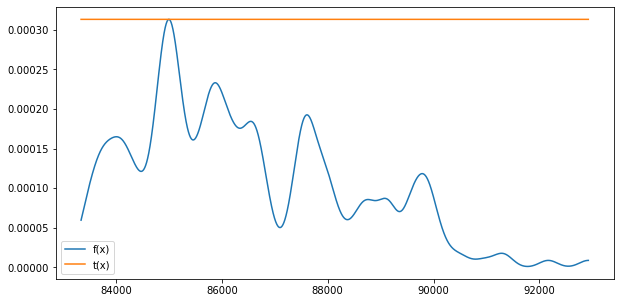

In [63]:
max_f1 = PDF1(x_grid1).max()
t1     = lambda x: max_f1 * np.ones([len(x)])

# Visualizacion de ambas funciones
plt.figure(figsize=(10,5))
plt.plot(x_grid1,PDF1(x_grid1),label='f(x)')
plt.plot(x_grid1,t1(x_grid1),label='t(x)')
plt.legend()
plt.show()

Variables Aleatorios con Estratos Constantes: BOTTAS


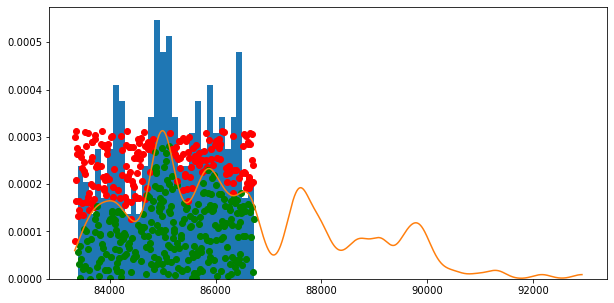

In [72]:
# I. Estratos constantes
N1     = 1300
a1     = min(vers)
b1     = max(vers)

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Estratos Constantes: BOTTAS')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = estratos_cttes(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_I  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1,263)

Variables Aleatorios con Números Complementarios: BOTTAS


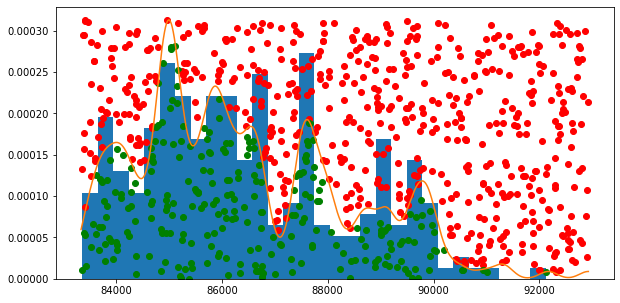

In [73]:
# II. Numeros complementarios

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Números Complementarios: BOTTAS')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = num_complem(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_II  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1, 263)
plt.show()

**Utilizando la técnica de reducción de varianza de números complementarios, se generan 53 valores de acuerdo a la distribución KDE con bandwidth óptimo.** Recordemos que cada valor representa el tiempo transcurrido en 1 vuelta al circuito.

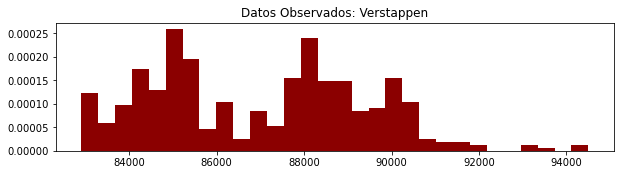

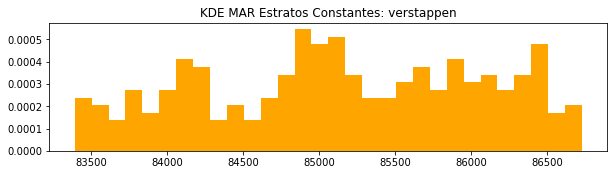

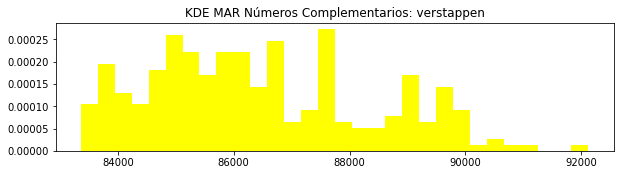

In [74]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(bot, density=True, bins=30,color="darkred")
plt.title('Datos Observados: Verstappen')
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_I, density=True, bins=30,color="orange")
plt.title("KDE MAR Estratos Constantes: verstappen")
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_II, density=True, bins=30, color="yellow")
plt.title('KDE MAR Números Complementarios: verstappen')
plt.show()

In [76]:
#Error relativo estratos constantes
np.mean(np.abs(vers-MAR1_I)/vers)

0.025658401165084412

In [78]:
#Error relativo num complementarios
np.mean(np.abs(vers-MAR1_II)/vers)

0.02483372386007687

In [83]:
Total_Verstappen = [sum(Acep_rechazo_na(np.random.rand(N1), num_complem(a1,b1,N1), PDF1, t1, 53)) for i in range(250)]
Resultados.Verstappen = Total_Verstappen

In [84]:
Resultados

,Hamilton,Bottas,Verstappen,Perez
0,4.582712e+06,4.590077e+06,4.560963e+06,NaN
1,4.605478e+06,4.603922e+06,4.566316e+06,NaN
2,4.619938e+06,4.559025e+06,4.587945e+06,NaN
3,4.585095e+06,4.580220e+06,4.582169e+06,NaN
4,4.580603e+06,4.593166e+06,4.601375e+06,NaN
...,...,...,...,...
245,4.589023e+06,4.579056e+06,4.579189e+06,NaN
246,4.634999e+06,4.592166e+06,4.596467e+06,NaN
247,4.655679e+06,4.580825e+06,4.572627e+06,NaN
248,4.620944e+06,4.597316e+06,4.624994e+06,NaN


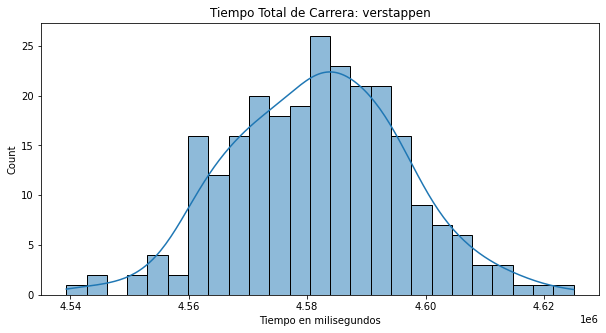

In [85]:
plt.figure(figsize=(10,5))
sns.histplot(Total_Verstappen, bins=25,kde=True)
plt.title("Tiempo Total de Carrera: verstappen")
plt.xlabel("Tiempo en milisegundos")
plt.show()

In [82]:
np.mean(Total_Verstappen)

4581827.543886616

## Cuarto Nodo: Pérez (RedBull)

In [ ]:
plt.figure(figsize=(2,2))
perz = perez['milliseconds'].to_numpy()
b4  = plt.boxplot(perz) 

In [ ]:
# eliminar los valores extremos
lims = [item.get_ydata()[1] for item in b4['whiskers']]
perz = perz[(perz > lims[0]) & (perz<lims[1])]
fig,(ax1,ax2) = plt.subplots(1,2,sharex= True, figsize=(16,4))
sns.histplot(perz, ax=ax2, bins=40)
sns.boxplot(x=perz, ax=ax1, saturation=.5, color='r')
print('Visualización Preliminar de Ditribución: PÉREZ')
plt.show()

En el histograma se aprecia que la distribución es **aproximadamente simétrica**, el histograma alude a una disribución trimodal.

### Ajuste de Distribuciones

In [ ]:
#warnings.filterwarnings('ignore')
plt.figure(figsize=(15,8))
y,x, _ = plt.hist(perz, bins=60, label='Datos',fc='gray', histtype='stepfilled', alpha=0.3, density=True)
x = x[1:]

# Tomamos las distribuciones continuas de la paqueteria 'scipy.stats'
dist = [d for d in dir(st) if isinstance(getattr(st,d), getattr(st,'rv_continuous'))]
dist = dist[3:20]+['gennorm']
#dist = dist[3:10] + dist[16:25] + dist[27:29] + dist[40:45] + dist[50:55]
#dist = ['johnsonsb', 'johnsonsu','kstwobign']
Error = pd.DataFrame(index=dist, columns=['RMSE','R-squared'])

[erdist(d,perz) for d in dist]
plt.title('Ajuste de Distribuciones: PÉREZ')
plt.show()

In [ ]:
bestRMSE = Error.sort_values(by='RMSE',ascending=True).head().index.values
bestR2   = Error.sort_values(by='R-squared',ascending=False).head().index.values
bestRMSE, bestR2

Basado en las dos métricas de error, se concluye que la distribución con mejor ajuste es **GENNORM**.

In [ ]:
measurements = perz

# Histograma de las variables creadas
divisiones = 60 # Cantidad de barras en el histograma
fig, ax = plt.subplots(3,1, figsize=(8,10))
fig.tight_layout(pad=3.0)

y, x, _ = ax[0].hist(measurements, divisiones, density=True, label='Datos observados')

# pdf con mejor ajuste segun RMSE y R^2: dgamma
dist = 'gennorm'
params = getattr(st, dist).fit(measurements)
st.gennorm.

# Graficar
# x = np.arange(measurements.min(), measurements.max(), .01)
y_hat = getattr(st, dist).pdf(x, *params)
ax[0].plot(x, y_hat,'r--', label=dist)
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()

# gráfica de Q-Q
# Usando scipy
grap2 = st.probplot(measurements, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
ax[1].grid()
ax[1].set_title('Usando paquete scipy')
# Usando stats
grap1 = sm.qqplot(measurements, dist=getattr(st, dist), line='s', fit=True, ax=ax[2])
ax[2].grid()
ax[2].set_title('Usando paquete stats')

# plt.xlabel(f'{dist.title()} theorical quantiles')
# plt.ylabel('Data theorical quantiles')
plt.show()

El gráfico Quantil-Quantil de la paquetería *stats* indica que los datos observados tiene menos variación que la distribución ajusta de stats. 

**Prueba de Hipótesis**

In [ ]:
print("Parámetros de la distribución dgamma \n","Beta: ",params[0],"\n","Loc: ",params[1],"\n","Scale: ",params[2])

In [ ]:
# Generar una distribucion dgamma con los parametros obtenidos
pi = st.gennorm.pdf(x, params[0], params[1], params[2]) #
# Chi cuadrado
Ei = x*pi
X2 = st.chisquare(y, Ei[1:])
print('Valor de chi cuadrado librería = ', X2)

**El p value es muy cercano a cero, se rechaza la hipótesis nula.**

### Kernel Density Estimation

In [ ]:
x_grid1 = np.linspace(min(perz),max(perz), 100000)

plt.figure(figsize=(10,5))
for bandwidth in [250,500,750]:
    plt.plot(x_grid1, kde_sklearn(perz, x_grid1, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
    
plt.hist(perz, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.title("KDE Cualitativo: PÉREZ")
plt.legend(loc='upper right')
plt.show()

Considerando que un bandwidth de 750 sobre-suaviza la distribución, acotamos el rango de posibles valores a aquellos menores a 500.

**Optimización de bandwidth**

In [ ]:
grid1 = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(100, 400, 100)},
                    cv=200) # 150-fold cross-validation
grid1.fit(perz[:, None])
print(grid1.best_params_)

In [ ]:
# Ajuste del KDE optimo
pdf_kde1 = KernelDensity(kernel='gaussian', bandwidth = 209.09).fit(perz[:, np.newaxis])
# Obtener una PDF de acuerdo al KDE óptimo.
PDF1 = lambda x: np.exp(pdf_kde1.score_samples(x[:, None]))

# graficar KDE con valor bw optimo
plt.figure(figsize=(10,5))
plt.plot(x_grid1, PDF1(x_grid1), label='bw=327.27',linewidth = 4)
plt.hist(perz, 60, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.legend(loc='upper right')
plt.title("KDE con Bandwidth Óptimo: PEREZ")
plt.show()

## Generar Variables Aleatorias

In [ ]:
max_f1 = PDF1(x_grid1).max()
t1     = lambda x: max_f1 * np.ones([len(x)])

# Visualizacion de ambas funciones
plt.figure(figsize=(10,5))
plt.plot(x_grid1,PDF1(x_grid1),label='f(x)')
plt.plot(x_grid1,t1(x_grid1),label='t(x)')
plt.legend()
plt.show()

In [ ]:
# I. Estratos constantes
N1     = 1300
a1     = min(hami)
b1     = max(hami)

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Estratos Constantes: PEREZ')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = estratos_cttes(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_I  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1,479)

In [ ]:
# II. Numeros complementarios

plt.figure(figsize=(10,5))
print('Variables Aleatorios con Números Complementarios: PEREZ')
R2_I = np.random.rand(N1) # uniformes entre 0 y 1
R1_I = num_complem(a1,b1,N1) # uniformes entre min y max de las muestras.
MAR1_II  = Acep_rechazo_n(R2_I, R1_I, PDF1, t1, 479)
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(bot, density=True, bins=30,color="darkred")
plt.title('Datos Observados: BOTTAS')
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_I, density=True, bins=30,color="orange")
plt.title("KDE MAR Estratos Constantes: BOTTAS")
plt.show()
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.hist(MAR1_II, density=True, bins=30, color="yellow")
plt.title('KDE MAR Números Complementarios: BOTTAS')
plt.show()

In [ ]:
#Error relativo estratos constantes
np.mean(np.abs(perz-MAR1_I[1:])/perz)

In [ ]:
#Error relativo num complementarios
np.mean(np.abs(perz-MAR1_II[1:])/perz)

# MonteCarlo

In [ ]:
Total_Perez = [sum(Acep_rechazo_na(np.random.rand(N1), num_complem(a1,b1,N1), PDF1, t1, 53)) for i in range(250)]
Resultados.Perez = Total_Perez